In [1]:
# importing dependencies
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# get subsets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
# checking the subsets
print(X_train.shape) 
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [4]:
# flattening the subsets
X_train = X_train.reshape(-1,784)
X_test = X_test.reshape(-1,784)

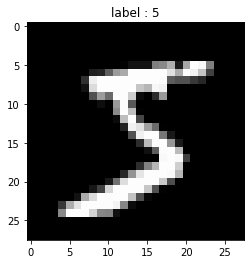

In [5]:
# visualize the data
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
plt.imshow(image, 'gray', vmin = 0, vmax = 255)
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [6]:
# pre processing
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min())

1.0
0.0


In [7]:
# splitting our subsets into train and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [8]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_val[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(48000,)
(48000, 10)
float64


In [9]:
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [10]:
# mini batch
class GetMiniBatch:
    """
Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [11]:
# calculating the batch
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)

In [12]:
print(len(get_mini_batch))

2400


[Problem 1] Creating a code to determine the initial weight value

In [13]:
n_sample,n_features = X_train.shape
n_nodes1 = 400
sigma = 0.01 # Standard deviation of Gaussian distribution
W1 = sigma * np.random.randn(n_features, n_nodes1)

In [14]:
print(n_nodes1)

400


### [Problem 1] Classifying fully connected layers

In [15]:
class FC():
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, layer_name):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.layer_name = layer_name
        self.initializer = initializer
        self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
        self.b = self.initializer.b(self.n_nodes2)
        pass

    def activation_function(self,X, af_name, layer_name):
      # if layer_name == "hidden" or layer_name == "first":
      #   act_f = np.tanh(X)
      #   return act_f
      # else: 
      #   act_f = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1, 1)
      #   return act_f
      if layer_name == "output":
        act_f = Softmax().calc(X)
        return act_f
      elif af_name == "tanh":
        act_f = Tanh().calc(X)
        return act_f
      elif af_name == "sigmoid":
        act_f = Sigmoid().calc(X)
        return act_f
      elif af_name == "softmax":
        act_f = Softmax().calc(X)
        return act_f
      elif af_name == "relu":
        act_f = ReLu().calc(X)
        return act_f
    
    def forward_propagation(self, X, af_name, layer_name):
      self.layer_pre = np.matmul(X,self.W) + self.b
      self.layer = self.activation_function(self.layer_pre, af_name, layer_name)
      return self.layer

    def backward_propagation(self, X, y, current_layer, next_layer, dZ, layer_name):
      self.dA = current_layer - y if layer_name == "output" else dZ*(1 - current_layer**2)
      self.db = np.sum(self.dA, axis=0)
      self.dW = next_layer.T @ self.dA if layer_name != "first" else X.T @ self.dA
      dZ = self.dA @ self.W.T
      # update
      self = self.optimizer.update(self)
      return dZ

### [Problem 2] Classifying the initialization method

In [16]:
class SimpleInitializer():
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
      return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    def b(self, n_nodes2):
      return self.sigma * np.random.randn(1, n_nodes2)

### [Problem 3] Classifying optimization methods

In [17]:
class SGD():
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
      layer.W -= self.lr * layer.dW
      layer.b -= self.lr * layer.db

### [Problem 4] Classifying activation functions

In [18]:
class Sigmoid():
  def __init__(self):
    pass
  
  def calc(self,X):
    return 1/(1+np.exp(-X))

class Tanh:
  def __init__(self):
    pass
  
  def calc(self,X):
    return np.tanh(X)

class Softmax:
  def __init__(self):
    pass
  
  def calc(self,X):
    return np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1, 1)

### [Problem 5] ReLU class creation

In [19]:
class ReLu():
  def __init__(self):
    pass
  
  def calc(self,X):
    return np.maximum(X,0)

### [Problem 6] Initial value of weight

In [20]:
class XavierInitializer():
  def __init__(self, sigma):
        self.sigma = sigma
  def W(self, n_nodes1, n_nodes2):
    return self.sigma * np.random.randn(n_nodes1, n_nodes2)/np.sqrt(n_nodes1)
  def b(self, n_nodes2):
    return self.sigma * np.random.randn(1, n_nodes2)

In [21]:
class HeInitializer():
  def __init__(self, sigma):
        self.sigma = sigma
  def W(self, n_nodes1, n_nodes2):
    return self.sigma * np.random.randn(n_nodes1, n_nodes2)/np.sqrt(2/n_nodes1)
  def b(self, n_nodes2):
    return self.sigma * np.random.randn(1, n_nodes2)

### [Problem 7] Optimization method

In [22]:
class Adagrad():
  def __init__(self,lr):
    self.lr = lr
    self.hW = 0
    self.hb = 0

  def update(self, layer):
    self.hW += layer.dW*layer.dW
    self.hb += layer.db*layer.db
    layer.W -= self.lr * layer.dW
    layer.b -= self.lr * layer.db
    return layer

### [Problem 8] Class completion

In [23]:
# neural network from scratch
class ScratchDeepNeuralNetrowkClassifier():
    def __init__(self, verbose = True, n_features=784,n_nodes1=400,n_nodes2=200, batch_size=20,n_output=10, n_epoch=10, lr=0.01, sigma=0.02, initializer_name="simple", optimizer_name="sdg", af_name="tanh"):
        self.verbose = verbose
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.batch_size = batch_size
        self.n_output = n_output
        self.n_epoch = n_epoch
        self.lr = lr
        self.sigma = sigma
        self.initializer_name = initializer_name
        self.optimizer_name = optimizer_name
        self.af_name = af_name
        self.loss = []
        self.val_loss = []
        pass
    
    def fit(self, X, y, X_val=None, y_val=None):
      self.create_init()
      for epoch in range(self.n_epoch):
          get_mini_batch = GetMiniBatch(X, y, self.batch_size)
          for mini_X_train, mini_y_train in get_mini_batch: 

            # forward propagation
            self.Z1 = self.FC1.forward_propagation(mini_X_train, self.af_name, "first")
            self.Z2 = self.FC2.forward_propagation(self.Z1, self.af_name, "hidden")
            self.Z3 = self.FC3.forward_propagation(self.Z2, self.af_name, "output")

            # backward propagation
            self.dZ2 = self.FC3.backward_propagation(None, mini_y_train, self.Z3, self.Z2 , None, "output")
            self.dZ1 = self.FC2.backward_propagation(None, mini_y_train, self.Z2, self.Z1 , self.dZ2, "hidden")
            self.dZ0 = self.FC1.backward_propagation(mini_X_train, mini_y_train, self.Z1, None , self.dZ1, "first")

          self.Z1 = self.FC1.forward_propagation(X, self.af_name, "first")
          self.Z2 = self.FC2.forward_propagation(self.Z1, self.af_name, "hidden")
          self.Z3 = self.FC3.forward_propagation(self.Z2, self.af_name, "output")

          self.loss.append(self.cross_entropy_error(y, self.Z3))

          if X_val is not None:
              self.Z1 = self.FC1.forward_propagation(X_val, self.af_name, "first")
              self.Z2 = self.FC2.forward_propagation(self.Z1, self.af_name, "hidden")
              self.Z3 = self.FC3.forward_propagation(self.Z2, self.af_name, "output")
              self.val_loss.append(self.cross_entropy_error(y_val, self.Z3))
          
          if self.verbose:
              # When verbose is set to True, the learning process etc. is output.
              print(self.loss)
          pass
    
    def create_init(self):
      # setting up the optimizer
      optimizer = None
      if self.optimizer_name == "sdg":
        optimizer = SGD(self.lr)
      elif self.optimizer_name == "adagrad":
        optimizer = Adagrad(self.lr)

      # setting up the initializer
      initializer = None
      if self.initializer_name == "simple":
        initializer = SimpleInitializer(self.sigma)
      elif self.initializer_name == "xavier":
        initializer = XavierInitializer(self.sigma)
      elif self.initializer_name == "he":
        initializer = HeInitializer(self.sigma)
      
      self.FC1 = FC(self.n_features, self.n_nodes1, initializer, optimizer, "first")
      self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer, optimizer, "hidden")
      self.FC3 = FC(self.n_nodes2, self.n_output, initializer, optimizer, "output")
    
    def activation_function(self,X, layer):
      if layer == "hidden" or layer == "first":
        act_f = np.tanh(X)
        return act_f
      else: 
        act_f = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1, 1)
        return act_f

    def cross_entropy_error(self, y, Z):
      return -np.sum([y[i]*np.log2(Z[i]) for i in range(len(y))])

    def predict(self, X):
      self.Z1 = self.FC1.forward_propagation(X, self.af_name, "first")
      self.Z2 = self.FC2.forward_propagation(self.Z1, self.af_name, "hidden")
      self.Z3 = self.FC3.forward_propagation(self.Z2, self.af_name, "output")
      return np.argmax(self.Z3, axis=1)

In [24]:
model = ScratchDeepNeuralNetrowkClassifier(verbose = False, n_features=784, n_nodes1=400, n_nodes2=200, batch_size=20, n_output=10, n_epoch=10, lr=0.01, sigma=0.02, initializer_name="simple", optimizer_name="sdg", af_name="tanh")
model.fit(X_train,y_train_one_hot,X_val,y_test_one_hot)
y_pred = model.predict(X_val)

In [25]:
accuracy_score(y_val, y_pred)

0.977

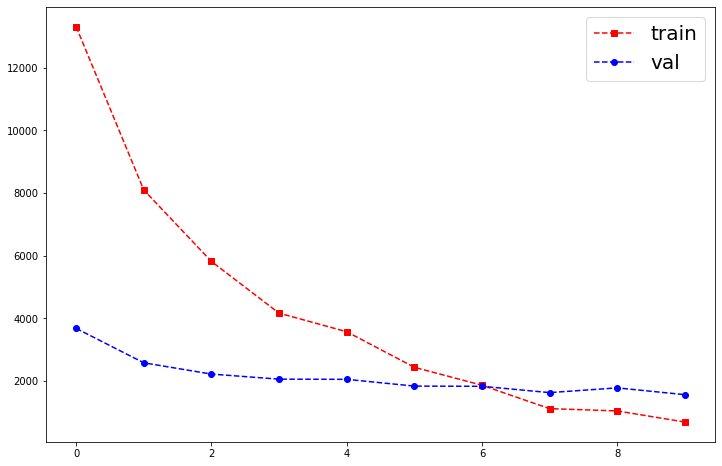

In [26]:
fig = plt.subplots(figsize=(12,8))
plt.rcParams["font.size"] = 20

plt.plot(model.loss,'rs--', label="train")
plt.plot(model.val_loss,'bo--', label= "val")
plt.legend()